In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

> How do we turn something that overfits into something that generalizes well to new data? In other words, how do we reduce the variance of a model? 

<center>An answer is <b>regularization</b> (at least sometimes).</center>

# Regularization for linear models

We'll look at the following methods:

1. Tikhonov regularization / ridge regression
2. Lasso regression
3. Elastic net
4. Early stopping

In [12]:
np.random.seed(seed)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

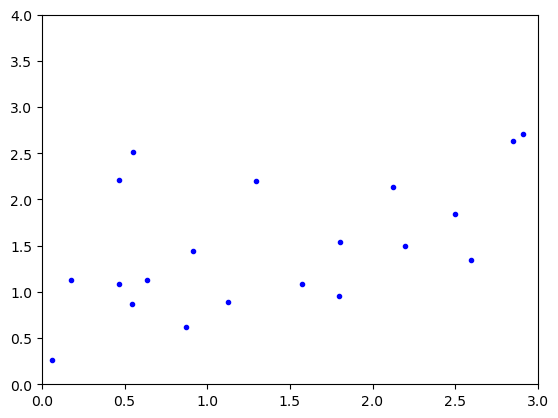

In [13]:
plt.plot(X,y, 'b.')
plt.axis([0, 3, 0, 4])
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

X_new = np.array([[0], [4]])
y_pred = lin_reg.predict(X_new)

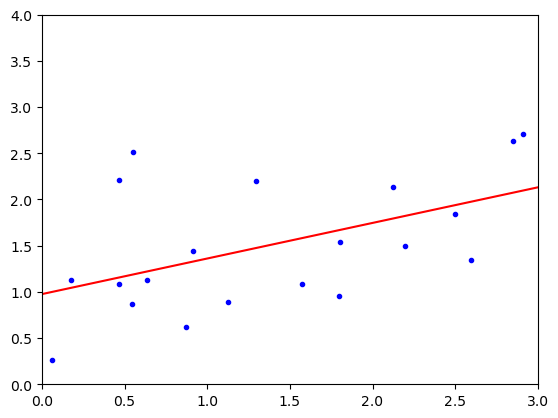

In [15]:
plt.plot(X,y, 'b.')
plt.plot(X_new, y_pred, 'r')
plt.axis([0, 3, 0, 4])
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [17]:
def get_polyreg(degree):
    poly_reg = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                            StandardScaler(), 
                             LinearRegression())
    
    return poly_reg

In [18]:
def plot_poly_regression(degree):
    poly_reg = get_polyreg(degree)
    poly_reg.fit(X, y)
    X_new = np.linspace(0, 4, 100).reshape(100, 1)
    y_pred = poly_reg.predict(X_new)
    plt.plot(X,y, 'b.')
    plt.plot(X_new, y_pred, 'r-')
    plt.axis([0, 3, 0, 4])
    plt.show()
    return poly_reg

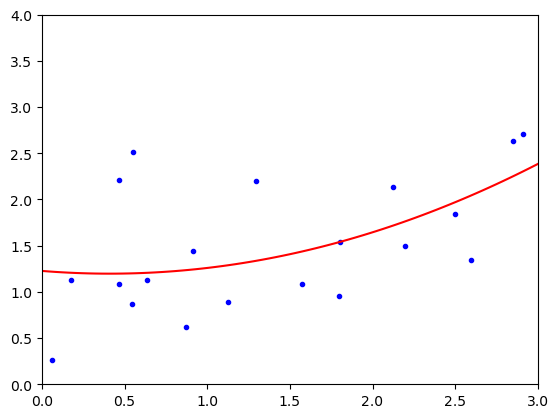

In [19]:
poly_reg_2 = plot_poly_regression(2)

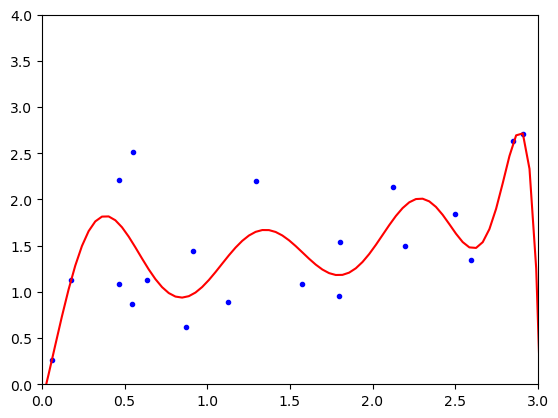

In [20]:
poly_reg_10 = plot_poly_regression(10)

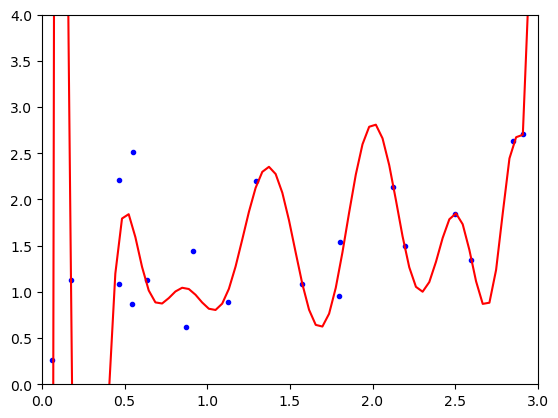

In [21]:
poly_reg_15 = plot_poly_regression(15)

In [22]:
poly_reg_15.named_steps['linearregression'].coef_

array([[ 4.42502296e+03, -1.56338798e+05,  2.60314759e+06,
        -2.59914137e+07,  1.71879179e+08, -7.93933126e+08,
         2.64229089e+09, -6.44673330e+09,  1.16116124e+10,
        -1.53997425e+10,  1.48372830e+10, -1.00927338e+10,
         4.59153996e+09, -1.25292160e+09,  1.54999105e+08]])

## Ridge regression

> A technique for making the coefficients smaller (_shrinkage_)

In [23]:
from sklearn.linear_model import Ridge

In [24]:
def get_ridgereg(degree, alpha):
    ridge_reg = make_pipeline(PolynomialFeatures(degree=degree),
                              StandardScaler(), 
                              Ridge(alpha=alpha))
    
    return ridge_reg

In [25]:
def plot_ridge_reg(degree, alpha):
    ridge_reg = get_ridgereg(degree, alpha)
    ridge_reg.fit(X, y)
    X_new = np.linspace(0, 4, 100).reshape(100, 1)
    y_pred = ridge_reg.predict(X_new)
    plt.plot(X,y, 'b.')
    plt.plot(X_new, y_pred, 'r-')
    plt.axis([0, 3, 0, 4])
    plt.show()
    return ridge_reg

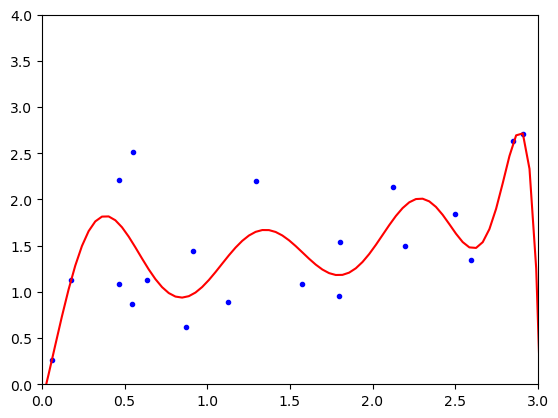

In [26]:
_ = plot_poly_regression(degree=10)
#vi kan se at vi får det samme som når vi bruke polynom regresjon tidligere
#grunnen er at alpha er 0, da blir det den samme MSE. Husk at regularization er å finne parameter som gir minst
#MSE. så hvis begge bruker MSE blir jo det sa lik fuksjon med lik parameter

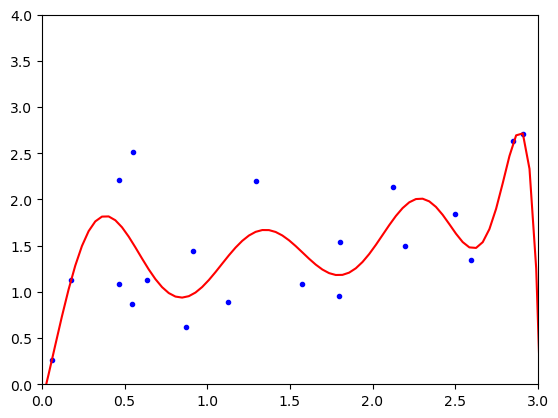

In [27]:
_ = plot_ridge_reg(degree=10,alpha=0)
#dette er beviset på at hvis alpha er 0, så blir det helt vanlig.
#altså:
#Hvis du setter α = 0, så betyr det at regulariseringen slås av — og da får du vanlig lineær regresjon
#(uten straff for store koeffisienter)

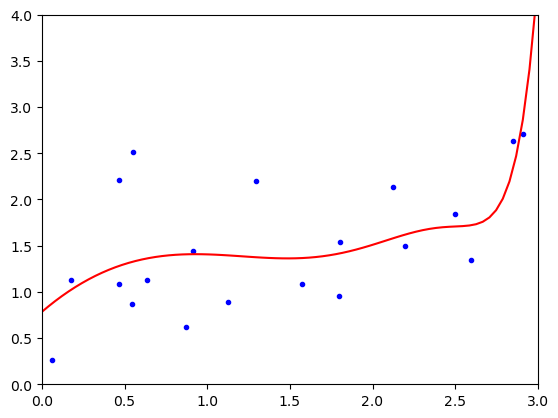

In [54]:
_ = plot_ridge_reg(20, 0.01)

## Lasso regression

> A technique for shrinking the coefficients to zero

Lasso regression (_Least Absolute Shrinkage and Selection Operator Regression_) is based on the same idea as ridge regression, but uses the $l_1$-norm instead of the $l_2$ norm:

$$\frac1m \sum_{i=1}^m \big(\theta \cdot \mathbf{x} - y^{(i)} \big)^2 + \alpha \sum_1^m |\theta_i|$$

In [48]:
from sklearn.linear_model import Lasso

In [49]:
def get_lassoreg(degree, alpha):
    lasso_reg = make_pipeline(PolynomialFeatures(degree=degree),
                              StandardScaler(), 
                              Lasso(alpha=alpha))
    
    return lasso_reg

In [50]:
def plot_lasso_reg(degree, alpha):
    lasso_reg = get_lassoreg(degree, alpha)
    lasso_reg.fit(X, y)
    X_new = np.linspace(0, 4, 100).reshape(100, 1)
    y_pred = lasso_reg.predict(X_new)
    plt.plot(X,y, 'b.')
    plt.plot(X_new, y_pred, 'r-')
    plt.axis([0, 3, 0, 4])
    plt.show()
    return lasso_reg

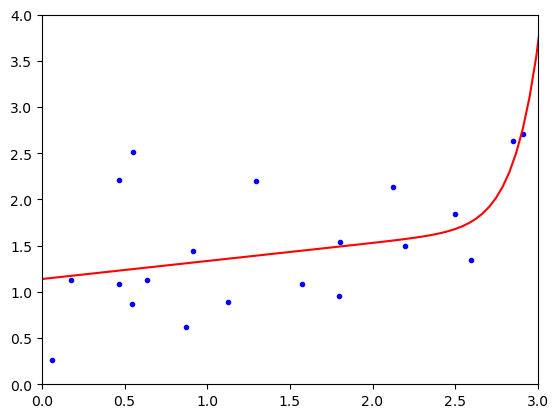

In [52]:
_ = plot_lasso_reg(20, 0.01)

In ridge regression, the higher-valued $\theta_i$ automatically get more penalized than they do in lasso regression since the $\theta_i$'s are squared in the cost function. 

This leads to lasso regression being more aggressive in eliminating weights altogether by setting them to zero. This is a form of **feature selection** (a continuous feature selection): Lasso tends to remove unimportant features from the model automatically.

## Elastic net

> A tradeoff between shrinking the coefficients to zero and making them small

This is simply a weighted average of ridge regression and lasso regression, with a hyperparameter $r$ that controls the mix ratio:

$$\frac1m \sum_{i=1}^m \big(\theta \cdot \mathbf{x} - y^{(i)} \big)^2 + r\cdot \alpha \sum_1^m |\theta_i| + \frac{1-r}{2} \cdot \alpha  \sum_1^m \theta_i^2$$

When $r=0$ elastic net is equal to ridge regression. When $r=1$ it's equal to lasso regression. 

In [55]:
from sklearn.linear_model import ElasticNet

In [56]:
#?ElasticNet

## Summary so far

> **When should you use linear regression, ridge, lasso or elastic net?**

* Plain linear regression is not in general a good idea. Always include some regularization.
* Use ridge unless you want the feature selection aspect of lasso (you suspect that only a few features are useful). But in that case, use elastic net with $r > 0$, not pure lasso.

## Early stopping

The idea of early stopping is simple: monitor the validation error during training, and stop the training once the validation performance error reaches a minimum (i.e., before it starts increasing). 

Early stopping is a different kind of regularization than ridge, lasso, and elastic net: instead of constraining the weights directly by modifying the cost function, you constrain the possible weight combinations by stopping the training early (i.e., restricting the reachable parameter space).

In [58]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [69]:
np.random.seed(42)
m_more = 100
X_more = 6 * np.random.rand(m_more, 1) - 3
y_more = 2 + X_more + 0.5 * X_more**2 + np.random.randn(m_more, 1)

X_train, X_val, y_train, y_val = train_test_split(X_more[:50], y_more[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = make_pipeline(
        PolynomialFeatures(degree=90, include_bias=False),
        StandardScaler())

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

In [70]:
from copy import deepcopy

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True, penalty=None, 
                       learning_rate="constant", eta0=0.0005, random_state=10)
# 'Warm start' makes the training start where it left off

minimum_val_error = float("inf")
best_epoch=None
best_model=None
for epoch in range(1001):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

In [65]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=10, tol=None, warm_start=True))

In [66]:
y_val_predict_best = best_model.predict(X_val_poly_scaled)

In [67]:
mean_squared_error(y_val_predict_best, y_val)

1.3192567103102857

In [68]:
minimum_val_error

1.3192567103102857